In [1]:
from funcs.WLANFuncs import *
from funcs.HelperFuncs import *

import itertools
from multiprocessing import Pool
import os
import pandas as pd
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

pd.options.display.float_format = '{:6f}'.format

import warnings
warnings.filterwarnings("ignore")


In [7]:
import pandas as pd

# Example Pandas Series (non-unique index)
data = {
    'index': ['A', 'B', 'A', 'C', 'B', 'C'],
    'values': [1, 2, 3, 4, 5, 6]
}

series = pd.Series(data['values'], index=data['index'])
print(series)


import numpy as np

# Group the values by index and convert to list
grouped = series.groupby(series.index).apply(np.array)

# Convert the grouped values to a NumPy 2D array
array_2d = np.array(grouped)

print(array_2d)


A    1
B    2
A    3
C    4
B    5
C    6
dtype: int64
[array([1, 3]) array([2, 5]) array([4, 6])]


## Setting configs


In [1]:
# Directory storing the CSI and WLAN captures
resources_dir = "/Volumes/tim_details/tim_honours/CAPTURES"

# Directory to save plots to
plt_dir = "/Users/timothylee/Desktop/Uni/Yr5/Honours/honours_thesis/figures/plt_figs/"

# Supress pd scientific notation
pd.set_option('display.float_format', '{:.6f}'.format)

# Resolution of plots
plt.rcParams["figure.dpi"] = 100 # 300
plt.rcParams["figure.dpi"] = 500 # 300

# Backend to generate plots
# mpl.use("agg")
# %matplotlib ipympl
%matplotlib inline

# plt figure style
fig_style = "seaborn-v0_8-whitegrid"

# colormaps
cmap_qual = "pastel"
cmap_seq = "viridis"
cmap_cycl = "twilight"


## Convert JSON to H5
good for ML, similar to csv, and efficiently stored with correct dtypes

### Also adding derivate features
* Is upstream/downstream

In [ ]:
procs = 4

ssid = "67Marlie"
pwd = "sayplease"

dirs = glob("/Volumes/tim_details/tim_honours/CAPTURES/*/*")

for dir in dirs:
    # Setting up dirs
    clean_dir_junk(os.path.join(dir, "wlan"))
    make_dir(os.path.join(dir, "wlan_json"))
    make_dir(os.path.join(dir, "wlan_h5"))
    # Running multiprocessing: wlan pcap to h5
    starargs = [(dir, get_name(i)) for i in os.listdir(os.path.join(dir, "wlan"))]
    with Pool(procs, initializer=wlan_to_df_init_mp, initargs=(ssid, pwd)) as pool:
        pool.starmap(wlan_to_df_mp, starargs)
    # Cleaning dirs (removing json dir)
    remove_dir(os.path.join(dir, "wlan_json"))

In [ ]:
fp = "/Volumes/tim_details/tim_honours/CAPTURES/client_pc_50/v=A3gUpodXMv0/wlan_h5/cap_15.h5"
display(pd.read_hdf(fp, key=H5_WLAN_KEY, mode="r"))

## Investigating streams

## Visualising cumulative bytes by time (binned in time intervals)

In [ ]:
# dirs = glob("/Users/timothylee/Desktop/Uni/Yr5/Honours/honours_dev/2_analyse/wlan_captures")
dirs = glob("/Volumes/tim_details/tim_honours/CAPTURES/*/*")

for dir in dirs:
    # Getting directory and file paths
    h5_dir = os.path.join(dir, "wlan_h5")
    plot_dir = os.path.join(dir, "wlan_plots")
    plot_fp = os.path.join(plot_dir, "all_cumsum.png")
    # Preparing directories
    make_dir(plot_dir)

    # If the plot already exists, then skip
    if os.path.isfile(plot_fp):
        continue

    # Making plots
    fig, ax = WLANFuncs.wlan_cumsum_plot(h5_dir)
    fig.savefig(plot_fp)
    fig.clf();
plt.close();

### Visualising bytes through time (V2)

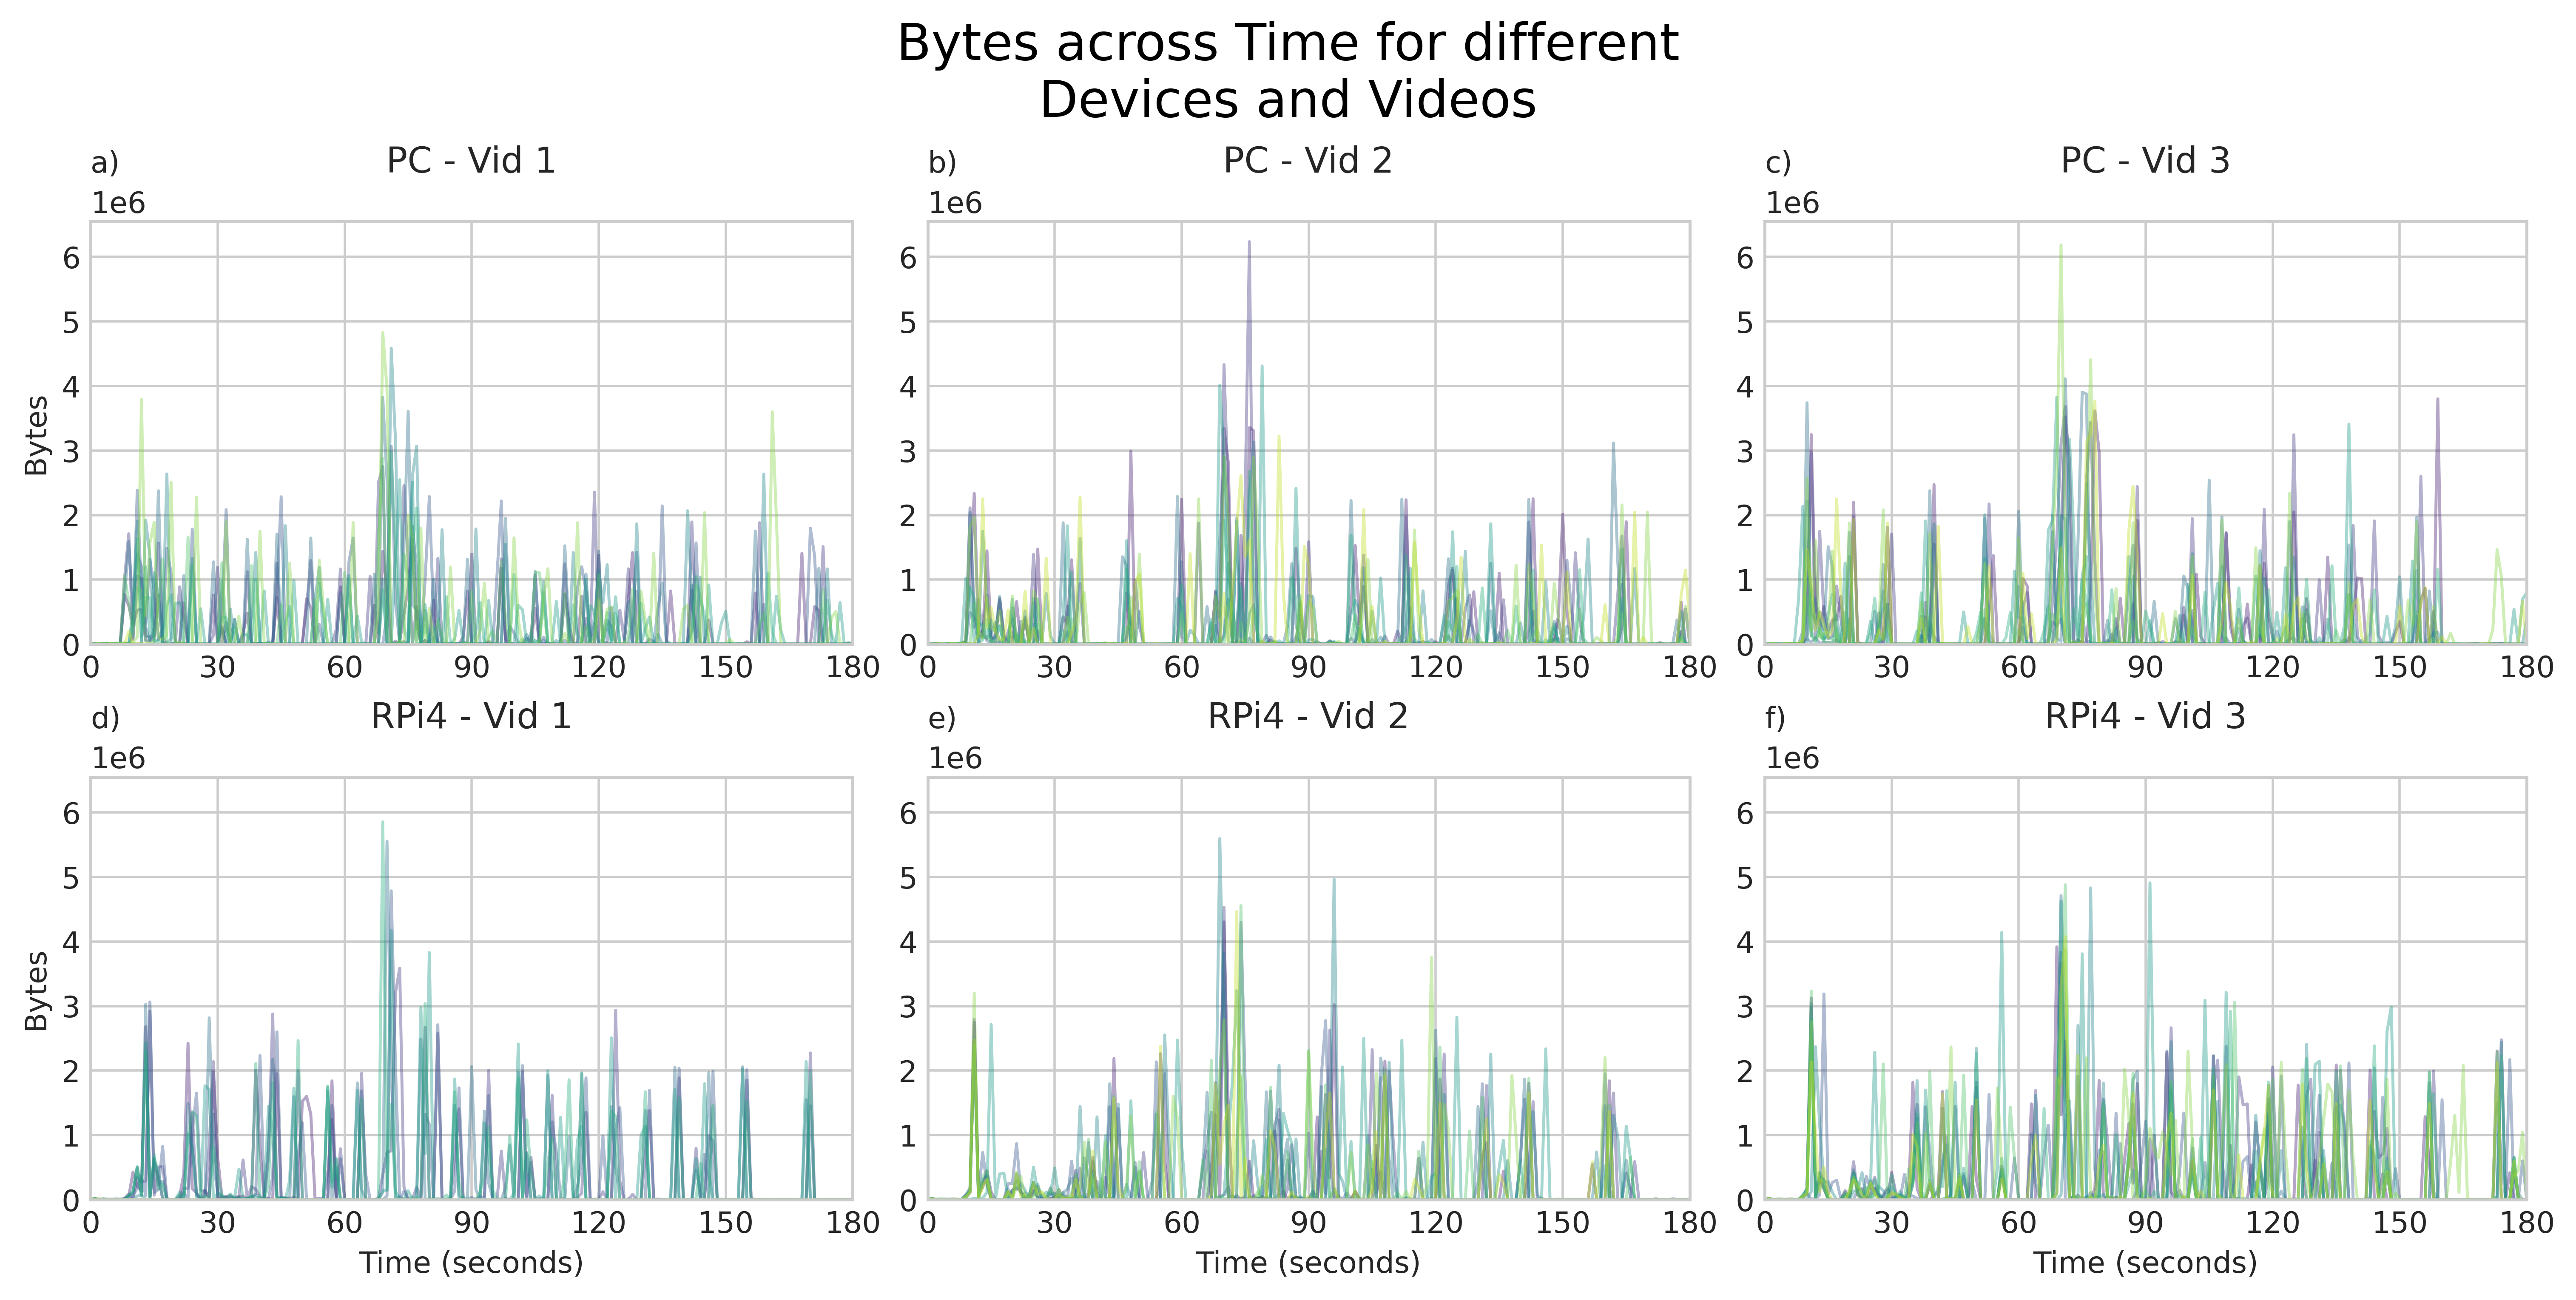

In [3]:
# Choosing labels and instances
devices = {
    "client_pc_200": "PC",
    "client_pi_200": "RPi4",
}
videos = {
    "v=A3gUpodXMv0": "Vid 1",
    "v=gxxqdrrpgZc": "Vid 2",
    "v=NSW5u1RTxEA": "Vid 3",
    # "v=mkWKZWMokdI": "Vid 4",
}
instances = [
    "cap_5",
    "cap_16",
    "cap_24",
    "cap_32",
    "cap_48",
    "cap_50",
    "cap_64",
    "cap_71",
    "cap_80",
    "cap_90",
]
labels = pd.DataFrame(columns=["devices", "videos", "instances"])
for i in itertools.product(devices, videos, instances):
    labels.loc[len(labels)] = i


# Grouping and aggregating data on time bins
agg_dict = {
    "frame": "count", # #frames
    "frame.len": "sum", # #bytes
}

# Making combined binned DF of all labels and instances
interval = 1 # Binning interval in seconds
df_binned_comb = pd.DataFrame()
for i in labels.index:
    # Getting the particular label details
    row = labels.loc[i]
    # Reading the wlan h5 file
    df = pd.read_hdf(
        os.path.join(resources_dir, row["devices"], row["videos"], "wlan_h5", f"{row['instances']}.h5"),
        key=H5_WLAN_KEY,
        mode="r",
    )
    # Adding a column to track the frame count
    df["frame"] = np.arange(df.shape[0])
    # Filtering (usually by upstream/downstream)
    # df = df[df["is_upstream"] == True]

    # Making the binned df
    df_binned = ts_bin_df(df, interval, agg_dict)
    # Imputing missing values
    df_binned = df_binned.fillna(0)
    # Calculating cumulative sums down the columns
    df_binned = pd.concat(
        [
            df_binned,
            df_binned.apply(np.nancumsum, axis=0).add_suffix("_cumsum"),
        ],
        axis=1,
    )

    # Adding label combo to group instances
    df_binned["labels"] = f"{devices[row['devices']]} - {videos[row['videos']]}"
    df_binned["instances"] = row["instances"]
    # Setting the ts_bins index as a column
    df_binned["ts_bins"] = df_binned.index

    # Concatenating the instance's binned df to the overall binned df
    df_binned_comb = pd.concat([df_binned_comb, df_binned], axis=0, ignore_index=True)

# Renaming columns
df_binned_comb = df_binned_comb.rename(
    columns={
        "frame": "Frames",
        "frame_cumsum": "Cumulative Frames",
        "frame.len": "Bytes",
        "frame.len_cumsum": "Cumulative Bytes",
    }
)

# PLOTTING
feature = "Bytes"
# Rows are classes and columns are features
with plt.style.context(fig_style):
    nrows=len(devices)
    ncols=len(videos)
    fig = plt.figure(figsize=(12, 6), layout="constrained")
    axes = fig.subplots(
        nrows=nrows,
        ncols=ncols,
    )
for i, dev in enumerate(devices.values()):
    # Making lineplots of each statistic
    for j, vid in enumerate(videos.values()):
        # Filtering df for the given label
        df_1 = df_binned_comb[df_binned_comb["labels"] == f"{dev} - {vid}"]
        # Plotting
        sns.lineplot(
            data=df_1,
            x="ts_bins",
            y=feature,
            hue="instances",
            palette=sns.color_palette(cmap_seq, len(instances)),
            alpha=0.4,
            linewidth=1.0,
            ax=axes[i, j],
        )
        # CUSTOMISING APPEARANCE
        # Removing legend
        axes[i, j].legend().remove()
        # Setting x-axis tick and limits
        axes[i, j].set_xticks(np.linspace(0, 180, 7, True))
        axes[i, j].set_xlim(0, 180)
        # Setting y-axis tick and limits
        axes[i, j].set_ylim(0, df_binned_comb[feature].max()*1.05)
        # Remove axes titles
        axes[i, j].set_xlabel(None)
        axes[i, j].set_ylabel(None)
        # Adding titles
        axes[i, j].set_title(f"{chr(ord('a')+i*ncols+j)})", loc='left', fontsize='medium')
        axes[i, j].set_title(f"{dev} - {vid}")

# Adding axes titles for the left and bottom edges
# bottom row x-axis - Time axis:
for i in np.arange(axes.shape[1]):
    axes[-1, i].set_xlabel("Time (seconds)")
# Left column y-axis - statistic/measure:
for i in np.arange(axes.shape[0]):
    axes[i, 0].set_ylabel(feature)
# Setting overall figure title
fig.suptitle("Bytes across Time for different\nDevices and Videos", fontsize="xx-large")

# Plot fig
fig.savefig(os.path.join(plt_dir, "MAC_intro_example.png"))
# fig.clf()
# plt.close()